In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.morphology import skeletonize
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Directories
input_directory = '/content/drive/MyDrive/Colab Notebooks/segmented_images'
output_directory = '/content/drive/MyDrive/Colab Notebooks/Processed_Images'
deNoized_directory = os.path.join(output_directory, 'DeNoized')
clustered_directory = os.path.join(output_directory, 'Clustered')
boundaries_directory = os.path.join(output_directory, 'Boundaries')
result_directory = os.path.join(output_directory, 'Result')
damaged_directory = os.path.join(output_directory, 'Damaged')

# Create directories if they don't exist
os.makedirs(deNoized_directory, exist_ok=True)
os.makedirs(clustered_directory, exist_ok=True)
os.makedirs(boundaries_directory, exist_ok=True)
os.makedirs(result_directory, exist_ok=True)
os.makedirs(damaged_directory, exist_ok=True)

In [ ]:
def de_noise_image(image_path):
    segment_image = cv.imread(image_path)
    deNoizedImage = cv.fastNlMeansDenoisingColored(segment_image, None, 10, 10, 7, 21)
    deNoizedImage_with_border = cv.copyMakeBorder(deNoizedImage, 1, 1, 1, 1, cv.BORDER_CONSTANT, value=[255, 255, 255])
    return deNoizedImage_with_border

def cluster_image(image, index):
    h, w, c = image.shape
    image_2d = image.reshape(h * w, c).astype(np.float32)
    numcolors = 3
    numiters = 10
    epsilon = 2
    attempts = 10
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, numiters, epsilon)
    ret, labels, centers = cv.kmeans(image_2d, numcolors, None, criteria, attempts, cv.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    newimage = centers[labels.flatten()]
    clustered_image = newimage.reshape(image.shape)
    cv.imwrite(f"{clustered_directory}/{index}_clustered.png", clustered_image)
    return clustered_image

def define_damage_mask(clustered_image):
    lower_green = np.array([36, 50, 70])
    upper_green = np.array([89, 255, 255])
    hsv_image = cv.cvtColor(clustered_image, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv_image, lower_green, upper_green)
    damaged_area = cv.bitwise_and(clustered_image, clustered_image, mask=mask)
    gray_image = cv.cvtColor(damaged_area, cv.COLOR_BGR2GRAY)
    return gray_image

def binarize_and_find_contours(gray_image):
    ret, binary = cv.threshold(gray_image, 100, 255, cv.THRESH_OTSU)
    contours, hierarchy = cv.findContours(binary, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    return contours

def extract_character_area(clustered_image):
    clustered_image_gray = cv.cvtColor(clustered_image, cv.COLOR_BGR2GRAY)
    ret, binary_map = cv.threshold(clustered_image_gray, 130, 255, 0)
    character_area = cv.cvtColor(binary_map, cv.COLOR_GRAY2BGR)
    return character_area

def draw_contours(character_area, contours, index):
    with_contours = cv.drawContours(character_area, contours, -1, (255, 0, 255), 1)
    cv.imwrite(f"{boundaries_directory}/{index}_damaged_boundaries.png", with_contours)
    return with_contours

def get_foreground_pixels(image):
    foreground_pixels = []
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if all(image[row, col] == [0, 0, 0]):
                foreground_pixels.append([row, col])
    return foreground_pixels

def mark_edge_pixels(with_contours, foreground_pixels):
    edge_pixels = []
    def mask3(y, x):
        mask = ([y-1,x-1], [y-1,x], [y-1,x+1], [y,x-1], [y,x+1], [y+1,x-1], [y+1,x], [y+1,x+1])
        for m in mask:
            if all(with_contours[m[0], m[1]] == [255, 0, 255]) and 0 <= m[0] < with_contours.shape[0] and 0 <= m[1] < with_contours.shape[1]:
                edge_pixels.append([y, x])
                with_contours[y, x] = [0, 255, 0]
    for fp in foreground_pixels:
        mask3(fp[0], fp[1])
    return edge_pixels

def get_final_result(with_contours, index):
    result_image = with_contours.copy()
    for row in range(result_image.shape[0]):
        for col in range(result_image.shape[1]):
            if all(with_contours[row, col] == [255, 0, 255]):
                result_image[row, col] = [255, 255, 255]
    cv.imwrite(f"{result_directory}/{index}_result.png", result_image)
    return result_image

def is_damaged_character(contours):
    return len(contours) > 0

# Get all image file names from the input directory
image_files = [f for f in os.listdir(input_directory) if f.endswith('.png') or f.endswith('.jpg')]

# Process all images
for i, image_file in enumerate(image_files):
    image_path = os.path.join(input_directory, image_file)
    index = os.path.splitext(image_file)[0]  # Use the file name without extension as index
    deNoizedImage_with_border = de_noise_image(image_path)
    clustered_image = cluster_image(deNoizedImage_with_border, index)
    gray_damage_mask = define_damage_mask(clustered_image)
    contours = binarize_and_find_contours(gray_damage_mask)
    character_area = extract_character_area(clustered_image)
    with_contours = draw_contours(character_area, contours, index)
    foreground_pixels = get_foreground_pixels(with_contours)
    edge_pixels = mark_edge_pixels(with_contours, foreground_pixels)
    final_result = get_final_result(with_contours, index)

    if is_damaged_character(contours):
        cv.imwrite(f"{damaged_directory}/{index}_damaged.png", final_result)


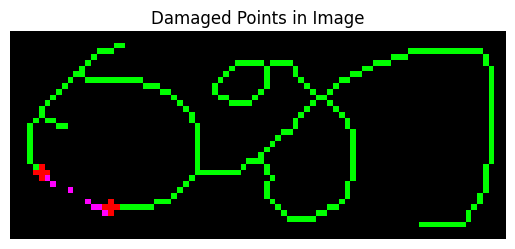

Damaged points found in image: [[24, 5], [30, 17]]
Number of missing pixels: 12
Number of total foreground pixels: 2859
Damage percentage: 0.42%
Processing file: segment_5_damaged.png
Closest point: [30, 17], Distance: 12, Damage Percentage: 0.42%



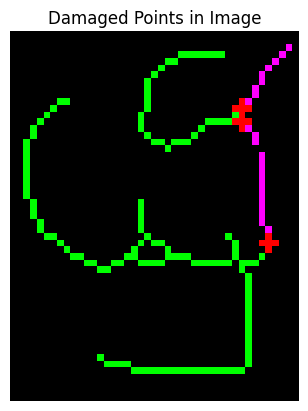

Damaged points found in image: [[11, 34], [13, 34], [31, 38]]
Number of missing pixels: 1
Number of total foreground pixels: 2198
Damage percentage: 0.05%
Processing file: segment_40_damaged.png
Closest point: [13, 34], Distance: 1, Damage Percentage: 0.05%



In [ ]:
# Directory for damaged images
damaged_directory = '/content/drive/MyDrive/Colab Notebooks/Processed_Images/Damaged'

# Function for thinning the image
def thinning(img):
    image = cv.bitwise_not(img)
    out = skeletonize(image // 255).astype(np.uint8) * 255
    return out

# Function to find damaged points in the image
def find_damaged_points(img):
    ends = []
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            if (img[row, col][0] == 0 and img[row, col][1] == 0 and img[row, col][2] == 255) or (img[row, col][0] == 255 and img[row, col][1] == 0 and img[row, col][2] == 0):
                ends.append([row, col])
    return ends

# Function to get all foreground pixels in the image
def find_damaged_points(img):
    ends = []

    # Ensure the image is in color (3 channels)
    if len(img.shape) == 2:  # If the image is grayscale
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)  # Convert to color (BGR)

    # Convert the image to grayscale to find edge pixels
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)[1]  # Convert to binary

    # Define the purple color in BGR (OpenCV uses BGR by default)
    purple = (255, 0, 255)

    # Define the 8-connected neighborhood
    kernel = np.ones((3, 3), np.uint8)

    # Find all foreground pixels
    foreground_pixels = np.where(binary == 255)
    for row, col in zip(foreground_pixels[0], foreground_pixels[1]):
        # Create a small region around the pixel
        region = img[row-1:row+2, col-1:col+2]

        # Check for the presence of purple pixels in the region
        if np.any(np.all(region == purple, axis=-1)):
            ends.append([row, col])

    # Draw the damaged points on the image
    img_with_damaged_points = img.copy()
    for (y, x) in ends:
        cv.circle(img_with_damaged_points, (x, y), 1, (0, 0, 255), -1)  # Draw a red circle

    # Convert the image to RGB if it's grayscale for matplotlib plotting
    if len(img.shape) == 2:
        img_with_damaged_points = cv.cvtColor(img_with_damaged_points, cv.COLOR_GRAY2RGB)

    # Plot the image with damaged points
    plt.imshow(cv.cvtColor(img_with_damaged_points, cv.COLOR_BGR2RGB))
    plt.title('Damaged Points in Image')
    plt.axis('off')
    plt.show()

    print(f'Damaged points found in image: {ends}')  # Debugging line
    return ends
#def get_foreground_pixels(img):
#    foreground_pixels = []
#    for row in range(img.shape[0]):
#        for col in range(img.shape[1]):
#            if (img[row, col][0] == 0 and img[row, col][1] == 0 and img[row, col][2] == 255) or (img[row, col][0] == 0 and img[row, col][1] == 255 and img[row, col][2] == 0):
#                foreground_pixels.append([row, col])
#    return foreground_pixels

# Function to calculate the distance between two points
def calc_distance(p1, p2):
    return round(np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)) - 1

# Function to calculate the damage percentage
def calc_damage_percentage(fore_pixels, miss_pixels):
    return (miss_pixels / (miss_pixels + fore_pixels)) * 100

# Function to find the closest damaged point to a new point
def closest(points, new_point):
    points = [i for i in points if i != new_point]
    closest_point = None
    closest_distance = None
    for point in points:
        distance = np.linalg.norm(np.array(point) - np.array(new_point))
        if closest_distance is None or distance < closest_distance:
            closest_point = point
            closest_distance = distance
    return closest_point, round(closest_distance) - 1

# Function to display damage percentage
def display_damaged_percentage(distance, foreground_pixels):
    total_foreground_pixels = len(foreground_pixels)
    print(f'Number of missing pixels: {distance}')
    print(f'Number of total foreground pixels: {total_foreground_pixels}')
    damage_percentage = calc_damage_percentage(total_foreground_pixels, distance)
    print(f'Damage percentage: {damage_percentage:.2f}%')
    return distance, total_foreground_pixels, damage_percentage

# Main processing function
def process_images(damaged_directory):
    image_files = [f for f in os.listdir(damaged_directory) if f.endswith('.png') or f.endswith('.jpg')]
    for image_file in image_files:
        image_path = os.path.join(damaged_directory, image_file)
        image = cv.imread(image_path)
        thinned_image = thinning(image)
        damaged_points = find_damaged_points(thinned_image)
        foreground_pixels = get_foreground_pixels(thinned_image)

        if damaged_points:
            # Use the first damaged point as the starting point
            new_point = damaged_points[0]
            closest_point, closest_distance = closest(damaged_points, new_point)
            distance, total_foreground_pixels, damage_percentage = display_damaged_percentage(closest_distance, foreground_pixels)
            print(f'Processing file: {image_file}')
            print(f'Closest point: {closest_point}, Distance: {closest_distance}, Damage Percentage: {damage_percentage:.2f}%\n')

# Run the main processing function
process_images(damaged_directory)


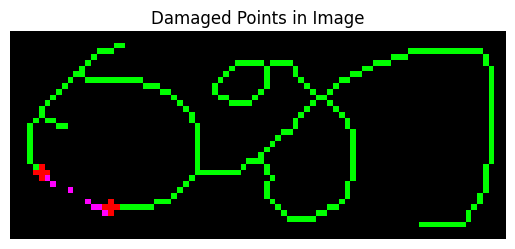

Damaged points found in image: [[24, 5], [30, 17]]
Number of missing pixels: 13.416407864998739
Number of total foreground pixels: 636
Damage percentage: 2.07%
Linking with a straight line in segment_5_damaged.png
Processed file: segment_5_damaged.png
Processed file: segment_5_damaged.png


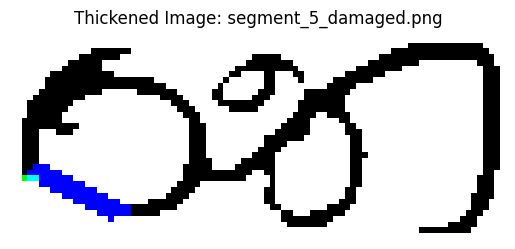

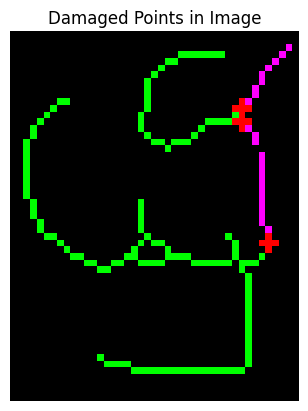

Damaged points found in image: [[11, 34], [13, 34], [31, 38]]
Handling multiple damaged points in segment_40_damaged.png
Number of missing pixels: 2.0
Number of total foreground pixels: 636
Damage percentage: 0.31%
Linking with a straight line in segment_40_damaged.png
Number of missing pixels: 2.0
Number of total foreground pixels: 636
Damage percentage: 0.31%
Linking with a straight line in segment_40_damaged.png
Number of missing pixels: 18.439088914585774
Number of total foreground pixels: 636
Damage percentage: 2.82%
Linking with curves in segment_40_damaged.png
Not enough points to calculate the curve
Not enough points to calculate the curve
Processed file: segment_40_damaged.png
Processed file: segment_40_damaged.png


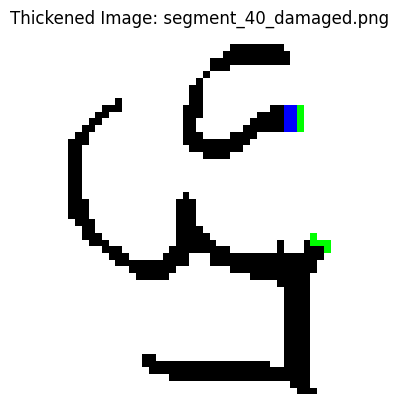

In [ ]:
# Helper function for finding control points and patterns
def findPattern(img, points):
    control_points = []
    pattern = []

    def findmc(c1, c2):
        """ Helper function to find the slope and intercept of a line given two points """
        m = (c2[1] - c1[1]) / (c2[0] - c1[0]) if (c2[0] - c1[0]) != 0 else float('inf')
        c = c1[1] - m * c1[0]
        return m, c

    def line_intersection(line1, line2):
        """ Find the intersection point of two lines """
        m1, c1 = findmc(line1[0], line1[1])
        m2, c2 = findmc(line2[0], line2[1])
        if m1 == m2:
            return None
        x = (c2 - c1) / (m1 - m2)
        y = m1 * x + c1
        return x, y

    def getValue(start, end, t):
        return int((1 - t) * start + t * end)

    for end in points:
        if end[0] == 0 or end[0] == img.shape[0] or end[1] == 0 or end[1] == img.shape[1]:
            continue

        line = [end]
        c1 = (end[0] - 1, end[1] - 1)
        c2 = end
        m, c = findmc(c1, c2)
        intercept_x_axis = ((img.shape[0] - 1) - c) / m
        if intercept_x_axis > img.shape[1] - 1:
            intercept_y_axis = ((img.shape[1] - 1) * m) + c
            if 0 <= intercept_y_axis < img.shape[0] - 1:
                line.append([intercept_y_axis, img.shape[1] - 1])
        else:
            line.append([img.shape[0] - 1, intercept_x_axis])

        control_points.append(line)
        pattern.append(1)

    # Process the control points to draw patterns
    for line in control_points:
      x_coords = [coord[1] for coord in line]
      y_coords = [coord[0] for coord in line]

      # Ensure there are enough points for curve calculation
      if len(x_coords) < 3 or len(y_coords) < 3:
        print("Not enough points to calculate the curve")
        continue

        curve_coordinates = []
        cnt = 10
        xFinal = []
        yFinal = []

        for i in range(cnt + 1):
            x0 = getValue(x_coords[0], x_coords[1], i / cnt)
            y0 = getValue(y_coords[0], y_coords[1], i / cnt)
            x1 = getValue(x_coords[1], x_coords[2], i / cnt)
            y1 = getValue(y_coords[1], y_coords[2], i / cnt)

            xFinal.append(getValue(x0, x1, i / cnt))
            yFinal.append(getValue(y0, y1, i / cnt))

        for x, y in zip(xFinal, yFinal):
            img[round(y), round(x)] = [255, 0, 0]

        pts = np.array([(sub[1], sub[0]) for sub in zip(yFinal, xFinal)], np.int32)
        isClosed = False
        color = (255, 0, 0)
        thickness = 1
        cv.polylines(img, [pts], isClosed, color, thickness)


    return img

# Main processing function
def process_images(damaged_directory):
    output_directory = '/content/drive/MyDrive/Colab Notebooks/Processed_Images/Thickked'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    image_files = [f for f in os.listdir(damaged_directory) if f.endswith('.png') or f.endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(damaged_directory, image_file)
        image = cv.imread(image_path)

        # Assuming thinning function is correctly defined
        thinned_image = thinning(image)
        damaged_points = find_damaged_points(thinned_image)

        if len(damaged_points) == 1 or len(damaged_points) == 0:
            print(f"Cannot reconstruct because only one or no damaged end tips in {image_file}")
            cv.imwrite(os.path.join(output_directory, image_file), image)
            kernel = np.ones((2, 2), np.uint8)
            thickened_image = cv.dilate(image, kernel, iterations=1)
            cv.imwrite(os.path.join(output_directory, "thickked_" + image_file), thickened_image)

        elif len(damaged_points) == 2:
            first_point, second_point = damaged_points
            distance = np.sqrt((first_point[0] - second_point[0]) ** 2 + (first_point[1] - second_point[1]) ** 2)
            # Assuming display_damaged_percentage function is correctly defined
            damaged_data = display_damaged_percentage(distance, foreground_pixels)
            ratio = round(math.sqrt(image.shape[0] ** 2 + image.shape[1] ** 2) / 100 * 20)

            if damaged_data[0] <= ratio:
                print(f"Linking with a straight line in {image_file}")
                cv.line(image, (first_point[1], first_point[0]), (second_point[1], second_point[0]), [255, 0, 0], 2)
                kernel = np.ones((2, 2), np.uint8)
                thickened_image = cv.dilate(image, kernel, iterations=1)
                cv.imwrite(os.path.join(output_directory, image_file), image)
                cv.imwrite(os.path.join(output_directory, "thickked_" + image_file), thickened_image)
            else:
                print(f"Linking with curves in {image_file}")
                points = [first_point, second_point]
                image = findPattern(image, points)
                kernel = np.ones((2, 2), np.uint8)
                thickened_image = cv.dilate(image, kernel, iterations=1)
                cv.imwrite(os.path.join(output_directory, image_file), image)
                cv.imwrite(os.path.join(output_directory, "thickked_" + image_file), thickened_image)

        else:
            print(f"Handling multiple damaged points in {image_file}")
            distance = 0
            damaged_pairs = []
            for p in damaged_points:
                closest_point = min((pt for pt in damaged_points if pt != p), key=lambda pt: np.sqrt((p[0] - pt[0]) ** 2 + (p[1] - pt[1]) ** 2), default=None)
                if closest_point:
                    distance += np.sqrt((p[0] - closest_point[0]) ** 2 + (p[1] - closest_point[1]) ** 2)
                    damaged_pairs.append((p, closest_point))
                    damaged_data = display_damaged_percentage(np.sqrt((p[0] - closest_point[0]) ** 2 + (p[1] - closest_point[1]) ** 2), foreground_pixels)
                    ratio = round(math.sqrt(image.shape[0] ** 2 + image.shape[1] ** 2) / 100 * 20)

                    if damaged_data[0] <= ratio:
                        print(f"Linking with a straight line in {image_file}")
                        cv.line(image, (p[1], p[0]), (closest_point[1], closest_point[0]), [255, 0, 0], 1)
                    else:
                        print(f"Linking with curves in {image_file}")
                        points = [p, closest_point]
                        image = findPattern(image, points)

            kernel = np.ones((2, 2), np.uint8)
            thickened_image = cv.dilate(image, kernel, iterations=1)
            cv.imwrite(os.path.join(output_directory, image_file), image)
            cv.imwrite(os.path.join(output_directory, "thickked_" + image_file), thickened_image)

        print(f'Processed file: {image_file}')
        print(f'Processed file: {image_file}')
        # Display the thickened image
        plt.imshow(cv.cvtColor(thickened_image, cv.COLOR_BGR2RGB))
        plt.title(f"Thickened Image: {image_file}")
        plt.axis('off')
        plt.show()

# Example usage
damaged_directory = '/content/drive/MyDrive/Colab Notebooks/Processed_Images/Damaged'
process_images(damaged_directory)
